# Get the Labels

In [7]:
import numpy as np
from astropy.io import fits # You might need to pip install this
import pylab as plt # only needed for verification
from sklearn.metrics import r2_score

In [9]:
path_labels = "./labels.fits"
allstar = fits.open(path_labels)

(5.0, 0.0)

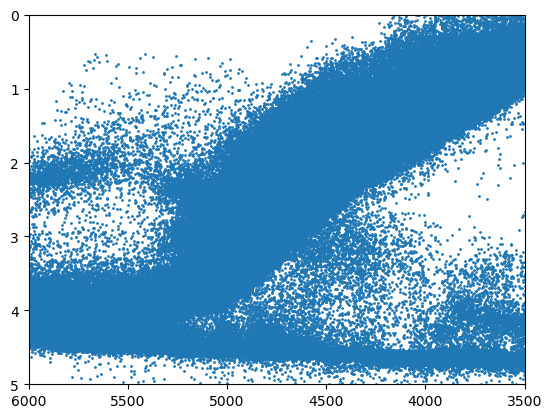

In [11]:
# the labels are in an enormous table in element [1] of this FITS file
labels = allstar[1].data
plt.scatter(labels['TEFF'], labels['LOGG'], s=1)
plt.xlim(6000, 3500)
plt.ylim(5, 0)

In [12]:
# make a reasonable red-giant-branch sample
RGB = True
RGB = np.logical_and(RGB, labels['TEFF'] > 3500.)
RGB = np.logical_and(RGB, labels['TEFF'] < 5400.)
RGB = np.logical_and(RGB, labels['LOGG'] < 3.0)
RGB = np.logical_and(RGB, labels['LOGG'] > 0.0)
RGB = np.logical_and(RGB, labels['H'] < 10.5)
print(np.sum(RGB))

145991


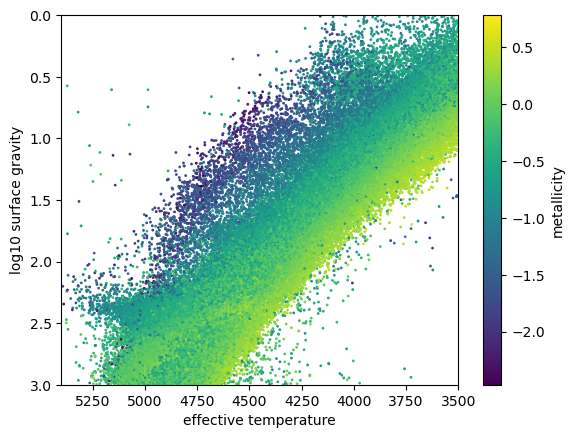

In [13]:
# make a plot that an astronomer likes to see
RGB_labels = labels[RGB]
plt.scatter(RGB_labels['TEFF'], RGB_labels['LOGG'], c=RGB_labels['FE_H'], s=1)
plt.xlim(5400, 3500)
plt.xlabel("effective temperature")
plt.ylim(3., 0.)
plt.ylabel("log10 surface gravity")
plt.colorbar(label="metallicity")

In [86]:
# make train, validation, and test data sets
rng = np.random.default_rng(17)
N_RGB = len(RGB_labels)
N_train, N_valid, N_test = 1024, 256, 512
I = rng.permutation(N_RGB)
I_train = I[0:N_train]
I_valid = I[N_train:N_train+N_valid]
I_test = I[N_train+N_valid:N_train+N_valid+N_test]

train_labels = RGB_labels[I_train]
valid_labels = RGB_labels[I_valid]
test_labels = RGB_labels[I_test]
print(len(train_labels), len(valid_labels), len(test_labels))

1024 256 512


Here how you get `LOGG`

In [89]:
train_labels_logg = train_labels['LOGG']
valid_labels_logg = valid_labels['LOGG']
test_labels_logg = test_labels['LOGG']

print(train_labels_logg.shape) # (num_spectra, 1)
train_labels_logg

(1024,)


array([0.5848838, 2.4330904, 2.334861 , ..., 1.8934093, 1.9242144,
       1.5278544], dtype='>f4')

# Get the Features

In [92]:
import numpy as np
from matplotlib import pyplot as plt

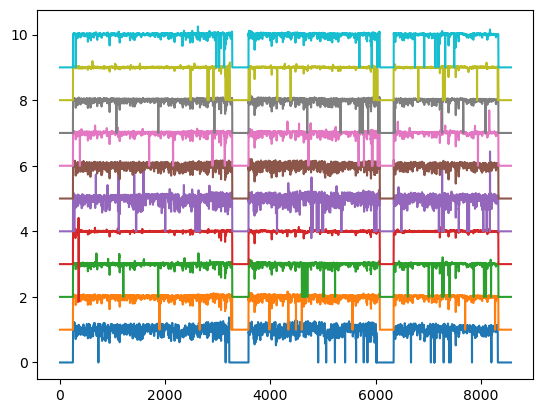

In [94]:
train_features = np.load('./train_features.npy')
valid_features = np.load('./valid_features.npy')
test_features = np.load('./test_features.npy')
for i in range(10):
    plt.plot(train_features[i] + i)

# MLP method

### import pytorch

In [98]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

print(torch.__version__)

2.10.0


### building the model

In [101]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2,hidden_size3, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size2)
        self.hidden2 = nn.Linear(hidden_size2, hidden_size3)
        self.output = nn.Linear(hidden_size3, output_size)
        self.activation = nn.LeakyReLU()

    
    def forward(self, x):
        '''
        Args
            x (torch.Tensor): Shape (batch_size, 8000)
        '''
        out = self.input(x) # (batch_size, hidden_size)
        out = self.activation(out) 
        out = self.hidden(out) # (batch_size, hidden_size2)
        out = self.activation(out)
        out = self.hidden2(out)
        out = self.activation(out)
        out = self.output(out) # (batch_size, 1) \neq (batch_size)
        return out

### import data

In [104]:
# Compute statistics ONLY from training data
mean = train_features.mean(axis=0)
std  = train_features.std(axis=0) + 1e-8   # avoid divide by zero

print("Mean shape:", mean.shape)
print("Std shape:", std.shape)

# Normalize training data
train_features = (train_features - mean[None, :]) / std

# Normalize validation data using TRAIN stats
valid_features = (valid_features - mean[None, :]) / std

# Normalize test data using TRAIN stats
test_features  = (test_features - mean[None, :]) / std

Mean shape: (8575,)
Std shape: (8575,)


In [106]:
print(np.shape(train_features))
train_features_tensor = torch.from_numpy(train_features).float()
valid_features_tensor = torch.from_numpy(valid_features).float()

(1024, 8575)


In [108]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_features_tensor, train_labels_logg)
val_dataset   = TensorDataset(valid_features_tensor, valid_labels_logg)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [110]:
model1 = MLP(input_size=8575, hidden_size=128*2, hidden_size2=128*2, hidden_size3=128*2, output_size=1)
model1(train_features_tensor).shape

torch.Size([1024, 1])

### training: finding the parameters

In [113]:
def run_optimization(num_epochs: int, optimizer, criterion):
    model1.train() # Enable dropout, batch norm training mode, etc.
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()   # Zero gradients from previous step
            
            output = model1(data) # Forward pass
            loss = criterion(output.squeeze(), target) # Compute loss ((batch_size, 1) \times (batch_size))
            
            loss.backward()         # Backpropagation
            optimizer.step()        # Update weights
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [115]:
# Optimizer
optimizer = optim.Adam(model1.parameters(), lr=1e-4)
# Loss Funciton
criterion = nn.MSELoss()
run_optimization(num_epochs=100, optimizer=optimizer, criterion=criterion)

Epoch 1/100, Loss: 0.8351
Epoch 2/100, Loss: 0.1110
Epoch 3/100, Loss: 0.0398
Epoch 4/100, Loss: 0.0247
Epoch 5/100, Loss: 0.0227
Epoch 6/100, Loss: 0.0181
Epoch 7/100, Loss: 0.0158
Epoch 8/100, Loss: 0.0169
Epoch 9/100, Loss: 0.0133
Epoch 10/100, Loss: 0.0131
Epoch 11/100, Loss: 0.0135
Epoch 12/100, Loss: 0.0126
Epoch 13/100, Loss: 0.0124
Epoch 14/100, Loss: 0.0118
Epoch 15/100, Loss: 0.0107
Epoch 16/100, Loss: 0.0091
Epoch 17/100, Loss: 0.0097
Epoch 18/100, Loss: 0.0105
Epoch 19/100, Loss: 0.0090
Epoch 20/100, Loss: 0.0077
Epoch 21/100, Loss: 0.0069
Epoch 22/100, Loss: 0.0056
Epoch 23/100, Loss: 0.0060
Epoch 24/100, Loss: 0.0066
Epoch 25/100, Loss: 0.0064
Epoch 26/100, Loss: 0.0062
Epoch 27/100, Loss: 0.0068
Epoch 28/100, Loss: 0.0069
Epoch 29/100, Loss: 0.0067
Epoch 30/100, Loss: 0.0071
Epoch 31/100, Loss: 0.0054
Epoch 32/100, Loss: 0.0057
Epoch 33/100, Loss: 0.0065
Epoch 34/100, Loss: 0.0055
Epoch 35/100, Loss: 0.0062
Epoch 36/100, Loss: 0.0070
Epoch 37/100, Loss: 0.0085
Epoch 38/1

### trainning fit

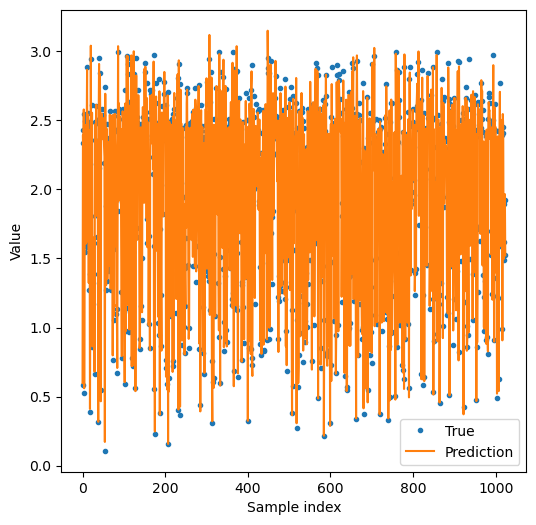

In [117]:
model1.eval()

with torch.no_grad():   # IMPORTANT
    x, y = train_dataset.tensors   # unpack tensors
    y_pred_test = model1(x).squeeze()

# If output is (N,1), flatten for plotting
y_pred_test = y_pred_test.squeeze()

plt.figure(figsize=(6,6))

plt.plot(y, 'o', markersize=3, label='True')
plt.plot(y_pred_test, '-', label='Prediction')

plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

### validation

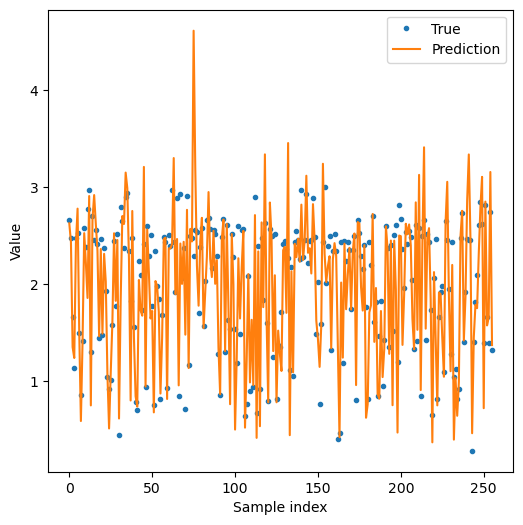

In [119]:
model1.eval()

with torch.no_grad():   # IMPORTANT
    x_val, y_val = val_dataset.tensors   # unpack tensors
    y_pred_valid = model1(x_val)

# If output is (N,1), flatten for plotting
y_pred_valid = y_pred_valid.squeeze()

plt.figure(figsize=(6,6))

plt.plot(y_val, 'o', markersize=3, label='True')
plt.plot(y_pred_valid, '-', label='Prediction')

plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

In [158]:
r2_MLP = r2_score(valid_labels_logg, y_pred_valid)
print("R²_MLP:", r2_MLP)

R²_MLP: 0.6953716030444957


## KNN method

In [160]:
from sklearn.neighbors import KNeighborsClassifier  # or KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

model2 = KNeighborsRegressor(n_neighbors=4)
model2.fit(train_features, train_labels_logg)

KNeighborsRegressor(n_neighbors=4)

In [168]:
y_pred_KNN = model2.predict(valid_features)

In [170]:
r2_KNN = r2_score(valid_labels_logg, y_pred_KNN)
print("R²_KNN:", r2_KNN)

R²_KNN: 0.8832604289054871


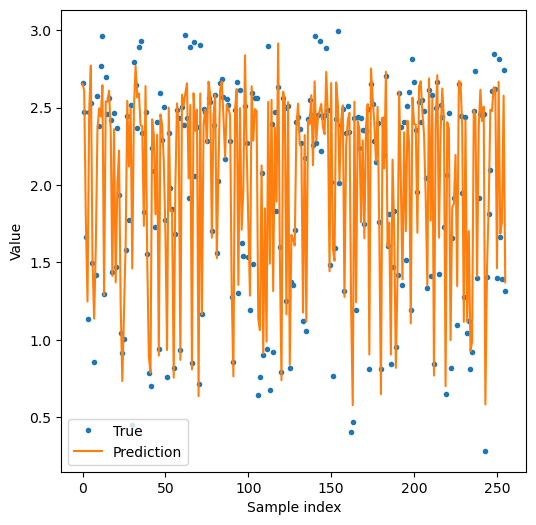

In [172]:
plt.figure(figsize=(6,6))

plt.plot(valid_labels_logg, 'o', markersize=3, label='True')
plt.plot(y_pred_KNN, '-', label='Prediction')

plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

## Linear Regression

In [125]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [126]:
model3 = LinearRegression()
model3.fit(train_features, train_labels_logg)

LinearRegression()

### validation

In [128]:
y_pred_LR = model3.predict(valid_features)

In [154]:
r2_LR = r2_score(valid_labels_logg, y_pred_LR)
print("R²_LR:", r2_LR)

R²_LR: 0.6453495900130966


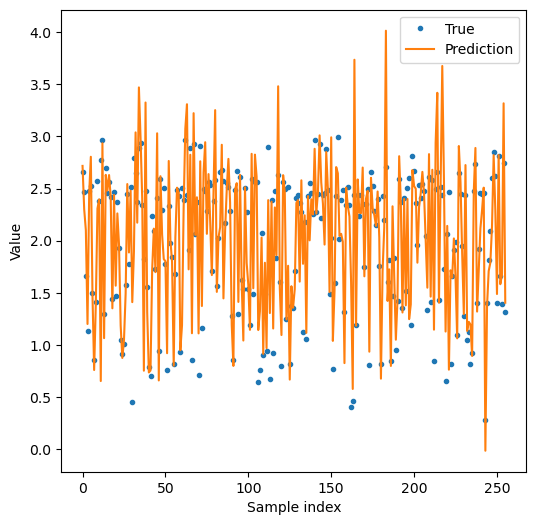

In [129]:
plt.figure(figsize=(6,6))

plt.plot(valid_labels_logg, 'o', markersize=3, label='True')
plt.plot(y_pred_LR, '-', label='Prediction')

plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.show()

## Running 3 models on the test data

In [131]:
model1.eval()

with torch.no_grad():   # IMPORTANT
    test_features_tensor = torch.from_numpy(test_features).float()
    y_pred_MLP_test = model1(test_features_tensor)

# If output is (N,1), flatten for plotting
y_pred_MLP_test = y_pred_MLP_test.squeeze()

In [132]:
y_pred_LR_test = model3.predict(test_features)
y_pred_KNN_test = model2.predict(test_features)

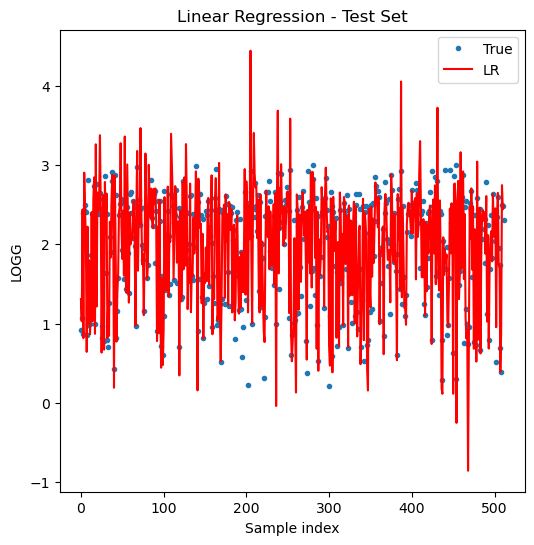

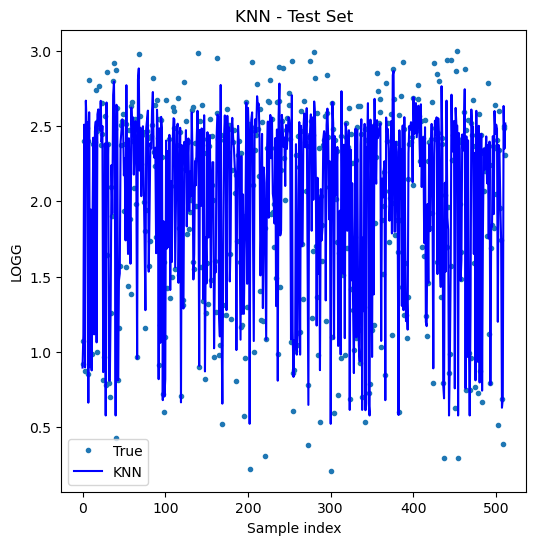

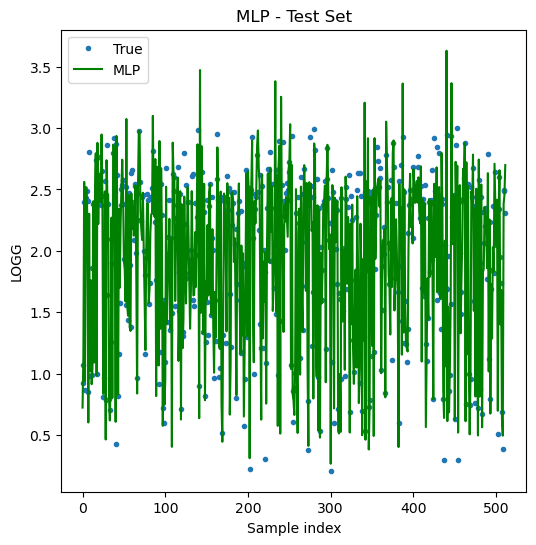

In [133]:
# ----- Linear Regression -----
plt.figure(figsize=(6,6))
plt.plot(test_labels_logg, 'o', markersize=3, label='True')
plt.plot(y_pred_LR_test, '-', color='red', label='LR')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("LOGG")
plt.title("Linear Regression - Test Set")
plt.show()


# ----- KNN -----
plt.figure(figsize=(6,6))
plt.plot(test_labels_logg, 'o', markersize=3, label='True')
plt.plot(y_pred_KNN_test, '-', color='blue', label='KNN')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("LOGG")
plt.title("KNN - Test Set")
plt.show()


# ----- MLP -----
plt.figure(figsize=(6,6))
plt.plot(test_labels_logg, 'o', markersize=3, label='True')
plt.plot(y_pred_MLP_test, '-', color='green', label='MLP')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("LOGG")
plt.title("MLP - Test Set")
plt.show()

### Performance of models:

In [137]:
from sklearn.metrics import mean_squared_error

mse_LR = mean_squared_error(test_labels_logg, y_pred_LR_test)
mse_MLP = mean_squared_error(test_labels_logg, y_pred_MLP_test)
mse_KNN = mean_squared_error(test_labels_logg, y_pred_KNN_test)

print("MSE_LR:", mse_LR)
print("MSE_MLP:", mse_MLP)
print("MSE_KNN:", mse_KNN)

MSE_LR: 0.14383937276328007
MSE_MLP: 0.09703106
MSE_KNN: 0.050467826


In [138]:
from sklearn.metrics import r2_score

r2_LR = r2_score(test_labels_logg, y_pred_LR_test)
r2_MLP = r2_score(test_labels_logg, y_pred_MLP_test)
r2_KNN = r2_score(test_labels_logg, y_pred_KNN_test)

print("R²_LR:", r2_LR)
print("R²_MLP:", r2_MLP)
print("R²_KNN:", r2_KNN)

R²_LR: 0.6878847462103082
R²_MLP: 0.7894535302931369
R²_KNN: 0.8904904723167419


# Summary

1. I used Mean Squared Error (MSE) and the R² score to evaluate the performance of my models.

2. After changing the random seed, I observed that the model performance varies across different data splits, indicating some sensitivity to the choice of seed.

3. After normalizing the features using statistics computed from the training set, all three models showed improved performance on the test set.

4. I used the validation set MSE to select the optimal hyperparameters for each model.